In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import svd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder,  StandardScaler
from matplotlib.pyplot import (figure, plot, title, xlabel, ylabel, 
                               colorbar, imshow, xticks, yticks, show)
from sklearn import model_selection, tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, DistanceMetric
from toolbox_02450 import train_neural_net, draw_neural_net, visualize_decision_boundary, rlr_validate
import numpy as np

import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import torch


## Import file

In [3]:
def load():# Load the heart csv data using the Pandas library
    filename = 'heart.csv'
    df = pd.read_csv(filename)
    return df


In [4]:
def outlier_removal(df):
   # Select columns 1 to 18
   selected_columns = df.iloc[:, 0:18]
   # Calculate basic summary statistics
   summary_statistics = selected_columns.describe()

   # Drop the data set to remove outlier
   df = df.drop(df[(df.BMI > summary_statistics.BMI['mean']+2*summary_statistics.BMI['std'])
            & (df.BMI < summary_statistics.BMI['mean']-2*summary_statistics.BMI['std'])
            & (df.PhysicalHealth > summary_statistics.PhysicalHealth['mean']+2*summary_statistics.PhysicalHealth['std'])
            & (df.PhysicalHealth < summary_statistics.PhysicalHealth['mean']-2*summary_statistics.PhysicalHealth['std'])
            & (df.MentalHealth > summary_statistics.MentalHealth['mean']+2*summary_statistics.MentalHealth['std'])
            & (df.MentalHealth < summary_statistics.MentalHealth['mean']-2*summary_statistics.MentalHealth['std'])
            & (df.SleepTime > summary_statistics.SleepTime['mean']+2*summary_statistics.SleepTime['std'])
            & (df.SleepTime < summary_statistics.SleepTime['mean']-2*summary_statistics.SleepTime['std'])].index)
   
   
   return df 

In [5]:
def balanced(df):
    # Balance the data
    # Count the number of 'yes' and 'no' values in the 'label' column
    yes_count = df['HeartDisease'].value_counts()['Yes']
    no_count = df['HeartDisease'].value_counts()['No']

    # Determine the label to balance (either 'yes' or 'no')
    label_to_balance = 'Yes' if yes_count > no_count else 'No'
    label_to_keep = 'Yes' if yes_count <= no_count else 'No'

    #remove after
    #columns_to_random = df[df['HeartDisease'] == label_to_keep].sample(n=100, random_state=42)
    
    # Calculate the difference in counts
    count_diff = yes_count 
    #count_diff = 100
    # Get the columns where the label is equal to label_to_balance
    columns_to_balance = df[df['HeartDisease'] == label_to_balance]

    # Randomly sample rows to make the counts equal
    sampled_rows = columns_to_balance.sample(n=count_diff, random_state=42)
    
    

    
    # Concatenate the sampled rows with the rows where the label is equal to label_to_keep
    balance = pd.concat([df[df['HeartDisease'] == label_to_keep], sampled_rows])
    #balance  = pd.concat([columns_to_random, sampled_rows])

    # Shuffle the rows to randomize the order
    balance = balance.sample(frac=1, random_state=42)

    df = balance 
    return df

In [6]:
def encode(df):
    # Transforme the discrete string into integer
    encoder = LabelEncoder()
    for col in df:
        if col != "BMI":
            df[col] = encoder.fit_transform(df[col])
    return df

In [7]:
def data_preprocess():
    df = load()
    df = outlier_removal(df)
    df = balanced(df)
    df = encode(df)
    return df

In [8]:
df = data_preprocess()
print(len(df['HeartDisease']))

54746


In [9]:
# Extract the data matrix, the class label and attribute names from the csv
raw_data = df.values

Data = raw_data[:,1:]
Label = df.values [:,0]
Attributes = np.asarray(df.columns[1:].str.slice(0, 3))

In [10]:
# Summary of Dataset in percentages
print(df['HeartDisease'].value_counts(normalize=True) * 100)

1    50.0
0    50.0
Name: HeartDisease, dtype: float64


In [11]:
# Transform to mean of 0 and standard deviation of 1
Data = Data/Data.std(axis=0)
Data = Data - Data.mean(axis=0)

In [12]:
# Assign each type of class with a number by making a Python dictionary
# and extract the class vector y, convert to NumPy array
classNames = np.unique(Label)
classDict = dict(zip(classNames,range(len(classNames))))

y = np.asarray([classDict[value] for value in Label])

In [13]:
# Compute values of number of data(N), attributes(M) and classes(C).
N = len(y)
M = len(Attributes)
C = len(classNames)

# ANN

In [52]:
# Define the hyperparameters grid to search
param_grid = {
    'hidden_units': [5, 10 , 15, 20, 25], # number of hidden units
    'lambdas': [  1.0, 10.0, 100, 1000,10000],
    'loss_fn': torch.nn.MSELoss(),
    'max_iter': 10000,
    'n_replicates': 3, # number of networks trained in each k-fold
    'K_inner' : 5,
    'K_outer' : 5
} 
       

# Define a function to create a Keras model with variable hidden units and regularization
def create_model(hidden_units=4,  M=17):
    model = lambda: torch.nn.Sequential(
                    torch.nn.Linear(M, hidden_units), #M features to H hiden units
                    # 1st transfer function, either Tanh or ReLU:
                    torch.nn.Tanh(),                            #torch.nn.ReLU(),
                    torch.nn.Linear(hidden_units, 1), # H hidden units to 1 output neuron
                    torch.nn.Sigmoid() # final tranfer function
                    )
    return model

In [47]:
def ridge_inner(X_train, X_test,y_train, y_test, col):
    
    w_rlr = np.empty((col))

    # Add offset attribute
    attributeNames = Attributes.tolist()
    X_train = np.concatenate((np.ones((X_train.shape[0],1)),X_train),1)
    X_test = np.concatenate((np.ones((X_test.shape[0],1)),X_test),1)
    col = col+1
    attributeNames = [u'Offset']+attributeNames


    opt_val_err, opt_lambda, _, _,_ = rlr_validate(X_train, y_train, param_grid['lambdas'], param_grid['K_inner'])
    
    # Standardize outer fold based on training set, and save the mean and standard
    # deviations since they're part of the model (they would be needed for
    # making new predictions) - for brevity we won't always store these in the scripts
    mu = np.mean(X_train[:, 1:], 0)
    sigma = np.std(X_train[:, 1:], 0)
    
    X_train[:, 1:] = (X_train[:, 1:] - mu ) / sigma
    X_test[:, 1:] = (X_test[:, 1:] - mu) / sigma
    
    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train
    
    # Estimate weights for the optimal value of lambda, on entire training set
    lambdaI = opt_lambda * np.eye(col)
    lambdaI[0,0] = 0 # Do no regularize the bias term
    w_rlr = np.empty((col))
    w_rlr = np.linalg.solve(XtX+lambdaI,Xty).squeeze()
    # Compute mean squared error with regularization with optimal lambda
    Error_test = np.square(y_test-X_test @ w_rlr).sum(axis=0)/y_test.shape[0]
    

    # #To inspect the weights for each attributes in this model
    # print('Weights in this fold:')
    # for m in range(M):
    #     print('{:>15} {:>15}'.format(attributeNames[m], np.round(w_rlr[m],2)))
    
    
    return  opt_lambda, round(Error_test,5)


In [48]:
def no_feature(y_train, y_test):
    # Compute mean squared error without using the input data at all
    print(y_test.mean())
    Error_test = np.square(y_test-y_test.mean()).sum(axis=0)/y_test.shape[0]
    # print( Error_test)
    return round(Error_test,5)

In [49]:
# Define a function to create a Keras model with variable hidden units and regularization
def create_model(hidden_units=4,  M=17):
    model = lambda: torch.nn.Sequential(
                    torch.nn.Linear(M, hidden_units), #M features to H hiden units
                    # 1st transfer function, either Tanh or ReLU:
                    torch.nn.Tanh(),                            #torch.nn.ReLU(),
                    torch.nn.Linear(hidden_units, 1), # H hidden units to 1 output neuron
                    # no final tranfer function, i.e. "linear output"
                    )
    return model

In [45]:
from sklearn.neural_network import MLPRegressor

def ANN_inner(X_train_outer, X_test_outer, y_train_outer, y_test_outer,M):
    
    
    # M = X_train.shape[1]
    w = np.empty((M,param_grid['K_inner'],len(param_grid['hidden_units'])))
    train_error = np.empty((param_grid['K_inner'],len(param_grid['hidden_units'])))
    test_error = np.empty((param_grid['K_inner'],len(param_grid['hidden_units'])))
    


    inner_cv = KFold(n_splits=param_grid['K_inner'], shuffle=True)

    errors = []
    for ik, (train_index, test_index) in enumerate(inner_cv.split(X_train_outer,y_train_outer)): 
        
        # Extract training and test set for current CV fold, 
        # and convert them to PyTorch tensors
        X_train_inner = X_train_outer[train_index,:] 
        y_train_inner = y_train_outer[train_index] 
        X_test_inner = X_train_outer[test_index,:] 
        y_test_inner = y_train_outer[test_index] 
        
        mu = np.mean(X_train_inner[:, 1:], 0)
        sigma = np.std(X_train_inner[:, 1:], 0)
        
        X_train_inner[:, 1:] = (X_train_inner[:, 1:] - mu) / sigma
        X_test_inner[:, 1:] = (X_test_inner[:, 1:] - mu) / sigma
        

        for h in range(0,len(param_grid['hidden_units'])):
            # Compute parameters for current value of hidden layer and current CV fold
           #model = create_model(param_grid['hidden_units'][h],M)
            # Start the training
            # net, final_loss, learning_curve = train_neural_net(model,
            #                                                 param_grid['loss_fn'],
            #                                                 X=,
            #                                                 y=,
            #                                                 n_replicates=param_grid['n_replicates'],
            #                                                 max_iter=param_grid['max_iter'])
            
            # Determine estimated class labels for test set
            #y_train_est = net(X_train_inner).squeeze()
            #y_test_est = net(torch.Tensor(X_test_inner)).squeeze()

            model = MLPRegressor(random_state=1, hidden_layer_sizes=(param_grid['hidden_units'][h],),max_iter=param_grid['max_iter']).fit(torch.Tensor(X_train_inner), torch.Tensor(y_train_inner))
            y_test_est = model.predict(torch.Tensor(X_test_inner))
            # # Determine errors and errors
            se = (y_test_est-y_test_inner)**2 # squared error
            mse = (sum(se)/len(y_test_inner)) #mean
            Error_test = np.square(y_test_est-y_test_inner).sum(axis=0)/y_test_inner.shape[0]
            
            test_error[ik, h] = mse # store error rate for current CV fold 
            
            # Evaluate training and test performance
            #train_error[ik,h] = np.power(y_train_est-y_train_inner,2).mean(axis=0)
            #test_error[ik,h] = np.power(y_test_est.detach().numpy()-y_test_inner,2).mean(axis=0)
    
    opt_hidden = param_grid['hidden_units'][np.argmin(np.mean(test_error,axis=0))]

    # model = create_model(opt_hidden,M)
    # # Train the model with the best hyperparameter on the entire training set (X_train_outer, y_train_outer)
    # Outer_net, Outer_final_loss, Outer_learning_curve = train_neural_net(model,
    #                                                                     param_grid['loss_fn'],
    #                                                                     X=torch.Tensor(X_train_outer),
    #                                                                     y=torch.Tensor(y_train_outer),
    #                                                                     n_replicates=param_grid['n_replicates'],
    #                                                                     max_iter=param_grid['max_iter'])

    # # Determine estimated class labels for test set
    # y_test_outer_est = Outer_net(torch.Tensor(X_test_outer)).squeeze()

    model = MLPRegressor(hidden_layer_sizes=(opt_hidden,),max_iter=param_grid['max_iter']).fit(X_train_outer, y_train_outer)
    y_test_outer_est = model.predict(torch.Tensor(X_test_outer))
    Outer_mse = np.square(y_test_outer_est-y_test_outer).sum(axis=0)/y_test_outer.shape[0]
    # # Determine errors and errors
    # Outer_se = (y_test_outer_est.float()-torch.Tensor(y_test_outer).float())**2 # squared error
    # Outer_mse = (sum(Outer_se).type(torch.float)/len(y_test_outer)).data.numpy() #mean
    #print('\n\tBest loss: {}'.format(final_loss), 'mse: {}\n'.format(Outer_mse))
    

    
    print(opt_hidden, Outer_mse)
    return opt_hidden, Outer_mse

In [53]:
        from sklearn.model_selection import train_test_split
        test_error = np.empty((1,len(param_grid['hidden_units'])))
        # Extract training and test set for current CV fold, 
        # extract training and test set
        X_train_inner, X_test_inner, y_train_inner, y_test_inner = train_test_split(Data,Label,test_size = 0.2)
        # X_train_outer = Data
        # y_train_outer = Label
        # train_index = range(100)
        # test_index = range(100,200)
        # Extract training and test set for current CV fold, 
        # and convert them to PyTorch tensors
        # X_train_inner = X_train_outer[train_index,:] 
        # y_train_inner = y_train_outer[train_index] 
        # X_test_inner = X_train_outer[test_index,:] 
        # y_test_inner = y_train_outer[test_index] 

        # Standardize the training and set set based on training set moments
        mu = np.mean(X_train_inner[:, 1:], 0)
        sigma = np.std(X_train_inner[:, 1:], 0)
        
        X_train_inner[:, 1:] = (X_train_inner[:, 1:] - mu) / sigma
        X_test_inner[:, 1:] = (X_test_inner[:, 1:] - mu) / sigma
        

        for h in range(0,len(param_grid['hidden_units'])):
            print(param_grid['hidden_units'][h])
            # Compute parameters for current value of hidden layer and current CV fold
           #model = create_model(param_grid['hidden_units'][h],M)
            # Start the training
            # net, final_loss, learning_curve = train_neural_net(model,
            #                                                 param_grid['loss_fn'],
            #                                                 X=,
            #                                                 y=,
            #                                                 n_replicates=param_grid['n_replicates'],
            #                                                 max_iter=param_grid['max_iter'])
            
            # Determine estimated class labels for test set
            #y_train_est = net(X_train_inner).squeeze()
            #y_test_est = net(torch.Tensor(X_test_inner)).squeeze()
            model = MLPRegressor(random_state=1, hidden_layer_sizes=(param_grid['hidden_units'][h],),max_iter=param_grid['max_iter']).fit(torch.Tensor(X_train_inner), torch.Tensor(y_train_inner))
            y_test_est = model.predict(torch.Tensor(X_test_inner))
            # # Determine errors and errors
            se = (y_test_est-y_test_inner)**2 # squared error
            mse = (sum(se)/len(y_test_inner)) #mean
            Error_test = np.square(y_test_est-y_test_inner).sum(axis=0)/y_test_inner.shape[0]
            
            test_error[0, h] = mse # store error rate for current CV fold 
        opt_hidden = param_grid['hidden_units'][np.argmin(np.mean(test_error,axis=0))]
        model = MLPRegressor(random_state=1, hidden_layer_sizes=(opt_hidden,),max_iter=param_grid['max_iter']).fit(X_train_inner, y_train_inner)
        y_test_inner_est = model.predict(torch.Tensor(X_test_inner))
        
        Outer_mse = np.square(y_test_inner_est-y_test_inner).sum(axis=0)/y_test_inner.shape[0]
        print(opt_hidden,Outer_mse)
        print(np.square(y_test_inner-y_test_inner.mean()).sum(axis=0)/y_test_inner.shape[0])
        # # Determine errors and errors

5
10
15
20
25
20 0.16842653764865154
0.24999959133462607


In [54]:
# Define the outer cross-validation splits
outer_cv = KFold(n_splits=param_grid['K_outer'], shuffle=True)

N, M = Data.shape

# Create a list to store the results for each hyperparameter value
results = []


# Initialize variables
#T = len(lambdas)
Error_test_ann = np.empty((param_grid['K_outer'],1))
Error_test_rlr = np.empty((param_grid['K_outer']))
Error_test_nofeatures = np.empty((param_grid['K_outer']))
opt_lambda_rlr = np.empty((param_grid['K_outer']))
opt_hidden_ann = np.empty((param_grid['K_outer']))

for ok, (train_outer_index, test_outer_index) in enumerate(outer_cv.split(Data,Label)):
    print('\nCrossvalidation outer fold: {0}/{1}'.format(ok+1,param_grid['K_outer']))


    # extract training and test set for current CV fold
    X_train_outer, X_test_outer = Data[train_outer_index,:], Data[test_outer_index,:]
    y_train_outer, y_test_outer = Label[train_outer_index], Label[test_outer_index]


    Error_test_nofeatures[ok] = no_feature(y_train_outer, y_test_outer)
    opt_lambda_rlr[ok], Error_test_rlr[ok] =  ridge_inner(X_train_outer, X_test_outer,y_train_outer, y_test_outer, M)
    print(opt_lambda_rlr[ok], Error_test_rlr[ok])


    
    opt_hidden_ann[ok], Error_test_ann[ok] = ANN_inner(X_train_outer, X_test_outer, y_train_outer,y_test_outer,M)
    # Store the best hyperparameter value and its corresponding score (MSE) for this outer fold


    # results.append(ridge_inner(X_train_outer, X_test_outer,y_train_outer, y_test_outer))

print( Error_test_nofeatures)
print(opt_lambda_rlr,Error_test_rlr)


Crossvalidation outer fold: 1/5
0.4979908675799087
100.0 0.17188
15 0.16423904833110026

Crossvalidation outer fold: 2/5
0.4977623527262764
100.0 0.17293
15 0.1657876614513396

Crossvalidation outer fold: 3/5
0.49684902730843
100.0 0.17316
15 0.16252768259663208

Crossvalidation outer fold: 4/5
0.5013243218558773
100.0 0.17338
15 0.16473457883248438

Crossvalidation outer fold: 5/5
0.5060736140286785
100.0 0.17115
15 0.16139947133282165
[0.25    0.24999 0.24999 0.25    0.24996]
[100. 100. 100. 100. 100.] [0.17188 0.17293 0.17316 0.17338 0.17115]


In [56]:
# Result saving
rlr = np.vstack((opt_lambda_rlr,  Error_test_rlr))
ann = np.vstack((opt_hidden_ann, Error_test_ann.squeeze()))
results = pd.DataFrame(np.vstack((Error_test_nofeatures,rlr,ann)), index=['baseline', ' lambda', 'err_rlr', 'n_hidden', 'err_ann'])
print(results)
results.to_csv('part2.csv', index=True)


                   0           1           2           3           4
baseline    0.250000    0.249990    0.249990    0.250000    0.249960
 lambda   100.000000  100.000000  100.000000  100.000000  100.000000
err_rlr     0.171880    0.172930    0.173160    0.173380    0.171150
n_hidden   15.000000   15.000000   15.000000   15.000000   15.000000
err_ann     0.164239    0.165788    0.162528    0.164735    0.161399


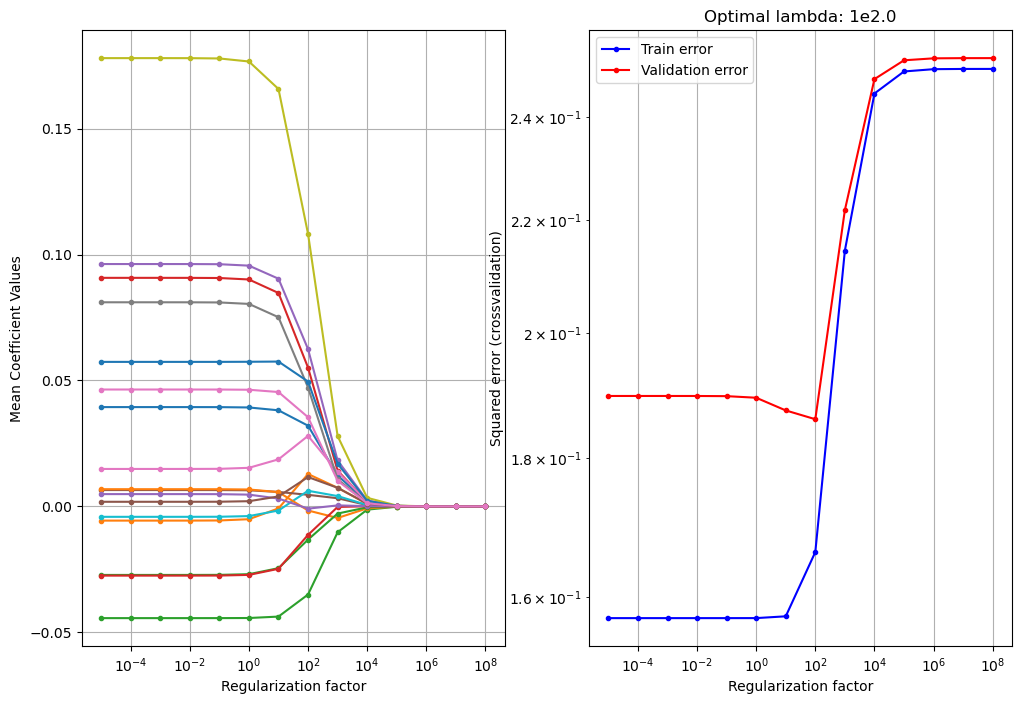

Linear regression without feature selection:
- Training error: 0.15876784413800824
- Test error:     0.15734667936289432
- R^2 train:     0.36492862344796706
- R^2 test:     0.37061328254842274

Regularized linear regression:
- Training error: 0.16640264572428234
- Test error:     0.16607656812433808
- R^2 train:     0.3343894171028706
- R^2 test:     0.3356937275026477

Weights in last fold:
         Offset             0.5
            BMI            0.03
            Smo            0.01
            Alc           -0.04
            Str            0.06
            Phy            0.06
            Men             0.0
            Dif            0.03
            Sex            0.05
            Age            0.11
            Rac            0.01
            Dia            0.05
            Phy            -0.0
            Gen           -0.01
            Sle           -0.01
            Ast            -0.0
            Kid            0.01
            Ski            0.04


In [34]:
from matplotlib.pylab import (figure, semilogx, loglog, xlabel, ylabel, legend,
                           title, subplot, show, grid)
import numpy as np
from scipy.io import loadmat
import sklearn.linear_model as lm
from sklearn import model_selection
from sklearn.model_selection import train_test_split


X = Data
attributeNames = Attributes.tolist()
N, M = X.shape

# Add offset attribute
X = np.concatenate((np.ones((X.shape[0],1)),X),1)
attributeNames = [u'Offset']+attributeNames
M = M+1

## Crossvalidation
# Create crossvalidation partition for evaluation
K = 1
#CV = model_selection.KFold(K, shuffle=False)

# Values of lambda
lambdas = np.power(10.,range(-5,9))

# Initialize variables
#T = len(lambdas)
Error_train = np.empty((K,1))
Error_test = np.empty((K,1))
Error_train_rlr = np.empty((K,1))
Error_test_rlr = np.empty((K,1))
Error_train_nofeatures = np.empty((K,1))
Error_test_nofeatures = np.empty((K,1))
w_rlr = np.empty((M,K))
mu = np.empty((K, M-1))
sigma = np.empty((K, M-1))
w_noreg = np.empty((M,K))

k = 0
# extract training and test set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.1)

internal_cross_validation = 10

opt_val_err, opt_lambda, mean_w_vs_lambda, train_err_vs_lambda, test_err_vs_lambda = rlr_validate(X_train, y_train, lambdas, internal_cross_validation)

# Standardize outer fold based on training set, and save the mean and standard
# deviations since they're part of the model (they would be needed for
# making new predictions) - for brevity we won't always store these in the scripts
mu[k, :] = np.mean(X_train[:, 1:], 0)
sigma[k, :] = np.std(X_train[:, 1:], 0)

X_train[:, 1:] = (X_train[:, 1:] - mu[k, :] ) / sigma[k, :]
X_test[:, 1:] = (X_test[:, 1:] - mu[k, :] ) / sigma[k, :]


Xty = X_train.T @ y_train
XtX = X_train.T @ X_train

# Compute mean squared error without using the input data at all
Error_train_nofeatures[k] = np.square(y_train-y_train.mean()).sum(axis=0)/y_train.shape[0]
Error_test_nofeatures[k] = np.square(y_test-y_test.mean()).sum(axis=0)/y_test.shape[0]

# Estimate weights for the optimal value of lambda, on entire training set
lambdaI = opt_lambda * np.eye(M)
lambdaI[0,0] = 0 # Do no regularize the bias term
w_rlr[:,k] = np.linalg.solve(XtX+lambdaI,Xty).squeeze()
# Compute mean squared error with regularization with optimal lambda
Error_train_rlr[k] = np.square(y_train-X_train @ w_rlr[:,k]).sum(axis=0)/y_train.shape[0]
Error_test_rlr[k] = np.square(y_test-X_test @ w_rlr[:,k]).sum(axis=0)/y_test.shape[0]

# Estimate weights for unregularized linear regression, on entire training set
w_noreg[:,k] = np.linalg.solve(XtX,Xty).squeeze()
# Compute mean squared error without regularization
Error_train[k] = np.square(y_train-X_train @ w_noreg[:,k]).sum(axis=0)/y_train.shape[0]
Error_test[k] = np.square(y_test-X_test @ w_noreg[:,k]).sum(axis=0)/y_test.shape[0]
# OR ALTERNATIVELY: you can use sklearn.linear_model module for linear regression:
#m = lm.LinearRegression().fit(X_train, y_train)
#Error_train[k] = np.square(y_train-m.predict(X_train)).sum()/y_train.shape[0]
#Error_test[k] = np.square(y_test-m.predict(X_test)).sum()/y_test.shape[0]

# Display the results for the last cross-validation fold
if k == K-1:
    figure(k, figsize=(12,8))
    subplot(1,2,1)
    semilogx(lambdas,mean_w_vs_lambda.T[:,1:],'.-') # Don't plot the bias term
    xlabel('Regularization factor')
    ylabel('Mean Coefficient Values')
    grid()
    # You can choose to display the legend, but it's omitted for a cleaner
    # plot, since there are many attributes
    #legend(attributeNames[1:], loc='best')

    subplot(1,2,2)
    title('Optimal lambda: 1e{0}'.format(np.log10(opt_lambda)))
    loglog(lambdas,train_err_vs_lambda.T,'b.-',lambdas,test_err_vs_lambda.T,'r.-')
    xlabel('Regularization factor')
    ylabel('Squared error (crossvalidation)')
    legend(['Train error','Validation error'])
    grid()

# To inspect the used indices, use these print statements
#print('Cross validation fold {0}/{1}:'.format(k+1,K))
#print('Train indices: {0}'.format(train_index))
#print('Test indices: {0}\n'.format(test_index))

k+=1

show()
# Display results
print('Linear regression without feature selection:')
print('- Training error: {0}'.format(Error_train.mean()))
print('- Test error:     {0}'.format(Error_test.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}\n'.format((Error_test_nofeatures.sum()-Error_test.sum())/Error_test_nofeatures.sum()))
print('Regularized linear regression:')
print('- Training error: {0}'.format(Error_train_rlr.mean()))
print('- Test error:     {0}'.format(Error_test_rlr.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train_rlr.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}\n'.format((Error_test_nofeatures.sum()-Error_test_rlr.sum())/Error_test_nofeatures.sum()))

print('Weights in last fold:')
for m in range(M):
    print('{:>15} {:>15}'.format(attributeNames[m], np.round(w_rlr[m,-1],2)))


In [38]:
def balanced_ANN(df):
    # Balance the data
    # Count the number of 'yes' and 'no' values in the 'label' column
    yes_count = df['HeartDisease'].value_counts()['Yes']
    no_count = df['HeartDisease'].value_counts()['No']

    # Determine the label to balance (either 'yes' or 'no')
    label_to_balance = 'Yes' if yes_count > no_count else 'No'
    label_to_keep = 'Yes' if yes_count <= no_count else 'No'

    #remove after
    columns_to_random = df[df['HeartDisease'] == label_to_keep].sample(n=100, random_state=42)
    
    # Calculate the difference in counts
    #count_diff = yes_count 
    count_diff = 100
    # Get the columns where the label is equal to label_to_balance
    columns_to_balance = df[df['HeartDisease'] == label_to_balance]

    # Randomly sample rows to make the counts equal
    sampled_rows = columns_to_balance.sample(n=count_diff, random_state=42)
    
    

    
    # Concatenate the sampled rows with the rows where the label is equal to label_to_keep
    #balance = pd.concat([df[df['HeartDisease'] == label_to_keep], sampled_rows])
    balance  = pd.concat([columns_to_random, sampled_rows])

    # Shuffle the rows to randomize the order
    balance = balance.sample(frac=1, random_state=42)

    df = balance 
    return df

In [39]:
df = load()
df = outlier_removal(df)
df = balanced_ANN(df)
df = encode(df)
# Extract the data matrix, the class label and attribute names from the csv
raw_data = df.values

Data = raw_data[:,1:]
Label = df.values [:,0]
Attributes= np.asarray(df.columns[1:].str.slice(0, 3))

# Assign each type of class with a number by making a Python dictionary
# and extract the class vector y, convert to NumPy array
classNames = np.unique(Label)
classDict = dict(zip(classNames,range(len(classNames))))

y = np.asarray([classDict[value] for value in Label])

# Compute values of number of data(N), attributes(M) and classes(C).
N = len(y)
M = len(Attributes)
C = len(classNames)

In [73]:
# Summary of Dataset in percentages
print(df['HeartDisease'].value_counts(normalize=True) * 100)

1    50.0
0    50.0
Name: HeartDisease, dtype: float64


In [74]:
len(Data)

200

['BMI' 'Smo' 'Alc' 'Str' 'Phy' 'Men' 'Dif' 'Sex' 'Age' 'Rac' 'Dia' 'Phy'
 'Gen' 'Sle' 'Ast' 'Kid' 'Ski']
Training model of type:

Sequential(
  (0): Linear(in_features=17, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=1, bias=True)
)


Crossvalidation fold: 1/3
67

	Replicate: 1/1
		Iter	Loss			Rel. loss


/Users/tinghui/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([133])) that is different to the input size (torch.Size([133, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


		1000	0.24700376	1.4478619e-06
		Final loss:
		1133	0.24695814	9.654201e-07

	Best loss: 0.24695813655853271

mse 0.28793368
tensor(0.2375)

Crossvalidation fold: 2/3
67

	Replicate: 1/1
		Iter	Loss			Rel. loss
		Final loss:
		734	0.25007054	9.5340437e-07

	Best loss: 0.2500705420970917

mse 0.25314438
tensor(0.2499)

Crossvalidation fold: 3/3
66

	Replicate: 1/1
		Iter	Loss			Rel. loss


/Users/tinghui/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([134])) that is different to the input size (torch.Size([134, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


		1000	0.24659821	1.4502431e-06
		Final loss:
		1104	0.24656357	9.66965e-07

	Best loss: 0.24656356871128082

mse 0.27102152
tensor(0.2353)
Diagram of best neural net in last fold:


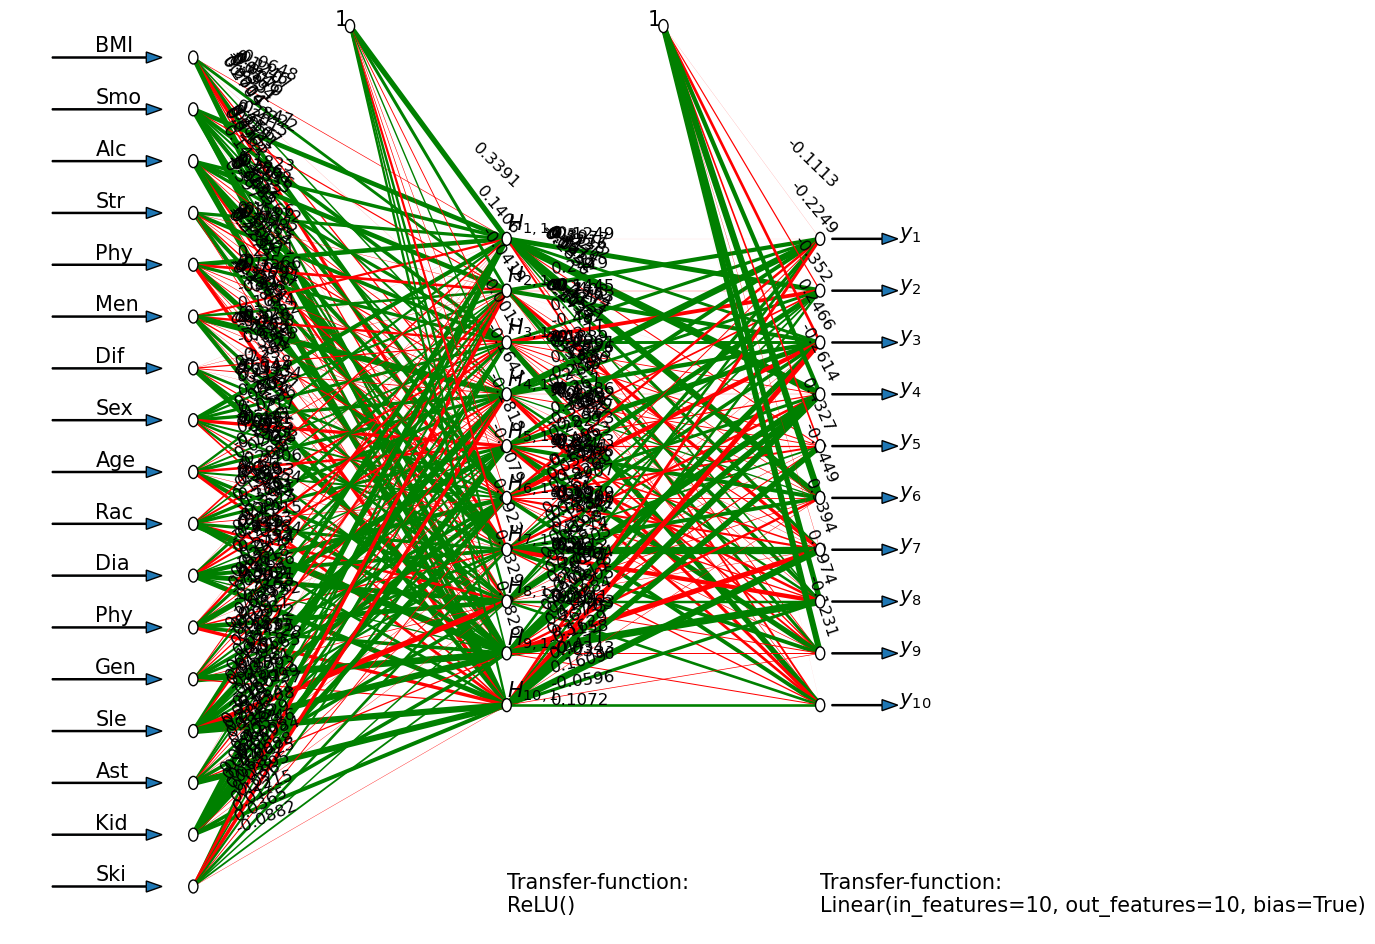


Estimated generalization error, RMSE: 0.5202999711036682


In [70]:
# exercise 8.2.6
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import torch
from sklearn import model_selection
from toolbox_02450 import train_neural_net, draw_neural_net
from scipy import stats

# Load Matlab data file and extract variables of interest
X = Data
y = Label
N, M = X.shape
C = 2

# Normalize data
X = stats.zscore(X)
Attributes= np.asarray(df.columns[1:].str.slice(0, 3)) 
attributeNames = Attributes.tolist()
print(Attributes)
## Normalize and compute PCA (change to True to experiment with PCA preprocessing)
do_pca_preprocessing = False
if do_pca_preprocessing:
    Y = stats.zscore(X,0)
    U,S,V = np.linalg.svd(Y,full_matrices=False)
    V = V.T
    #Components to be included as features
    k_pca = 3
    X = X @ V[:,:k_pca]
    N, M = X.shape


# Parameters for neural network classifier
n_hidden_units = 10      # number of hidden units
n_replicates = 1        # number of networks trained in each k-fold
max_iter = 10000

# K-fold crossvalidation
K = 3                   # only three folds to speed up this example
CV = model_selection.KFold(K, shuffle=True)


# Define the model
model = lambda: torch.nn.Sequential(
                    torch.nn.Linear(M, n_hidden_units), #M features to n_hidden_units
                    torch.nn.ReLU(),   # 1st transfer function,
                    torch.nn.Linear(n_hidden_units, n_hidden_units), #M features to n_hidden_units
                    torch.nn.ReLU(),   # 1st transfer function,
                    torch.nn.Linear(n_hidden_units, 1), # n_hidden_units to 1 output neuron
                    # no final tranfer function, i.e. "linear output"
                    )
loss_fn = torch.nn.MSELoss() # notice how this is now a mean-squared-error loss

print('Training model of type:\n\n{}\n'.format(str(model())))
errors = [] # make a list for storing generalizaition error in each loop
for (k, (train_index, test_index)) in enumerate(CV.split(X,y)): 
    print('\nCrossvalidation fold: {0}/{1}'.format(k+1,K))    
    
    # Extract training and test set for current CV fold, convert to tensors
    X_train = torch.Tensor(X[train_index,:])
    y_train = torch.Tensor(y[train_index])
    X_test = torch.Tensor(X[test_index,:])
    y_test = torch.Tensor(y[test_index])
    print(len(y_test))
    # Train the net on training data
    net, final_loss, learning_curve = train_neural_net(model,
                                                       loss_fn,
                                                       X=X_train,
                                                       y=y_train,
                                                       n_replicates=n_replicates,
                                                       max_iter=max_iter)
    
    print('\n\tBest loss: {}\n'.format(final_loss))
    
    # Determine estimated class labels for test set
    y_test_est = net(X_test).squeeze()
    #print(y_test_est)
    #print(y_test)
    # Determine errors and errors
    se = (y_test_est.float()-y_test.float())**2 # squared error
    mse = (sum(se).type(torch.float)/len(y_test)).data.numpy() #mean
    print('mse', mse)
    print(np.square(y_test-y_test.mean()).sum(axis=0)/y_test.shape[0])
    errors.append(mse) # store error rate for current CV fold 
    
print('Diagram of best neural net in last fold:')
weights = [net[i].weight.data.numpy().T for i in [0,2]]
biases = [net[i].bias.data.numpy() for i in [0,2]]
tf =  [str(net[i]) for i in [1,2]]
draw_neural_net(weights, biases, tf, attribute_names=attributeNames)
    

# Print the average classification error rate
print('\nEstimated generalization error, RMSE: {0}'.format(round(np.sqrt(np.mean(errors)), 4)))


['BMI' 'Smo' 'Alc' 'Str' 'Phy' 'Men' 'Dif' 'Sex' 'Age' 'Rac' 'Dia' 'Phy'
 'Gen' 'Sle' 'Ast' 'Kid' 'Ski']
Training model of type:
Sequential(
  (0): Linear(in_features=17, out_features=10, bias=True)
  (1): Tanh()
  (2): Linear(in_features=10, out_features=1, bias=True)
  (3): Sigmoid()
)


Crossvalidation fold: 1/4

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	0.2280508	0.0011179165
		2000	0.097064234	0.00062059716
		3000	0.052149653	0.00061802723
		4000	0.029611304	0.0006155059
		5000	0.016667461	0.00054606394
		6000	0.010292323	0.00040196307
		7000	0.00721634	0.0002960347
		8000	0.005687224	0.000212184
		9000	0.004438854	0.00020704107
		10000	0.0031887505	0.00011841836
		Final loss:
		10000	0.0031887505	0.00011841836

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	0.14621359	0.0012893776
		2000	0.049964823	0.0008958344
		3000	0.02278915	0.000678176
		4000	0.012429613	0.00061111146
		5000	0.0074258787	0.0004170217
		6000	0.0052163745	0.00030128183
		7000	0.004091272	0.00019424995
		

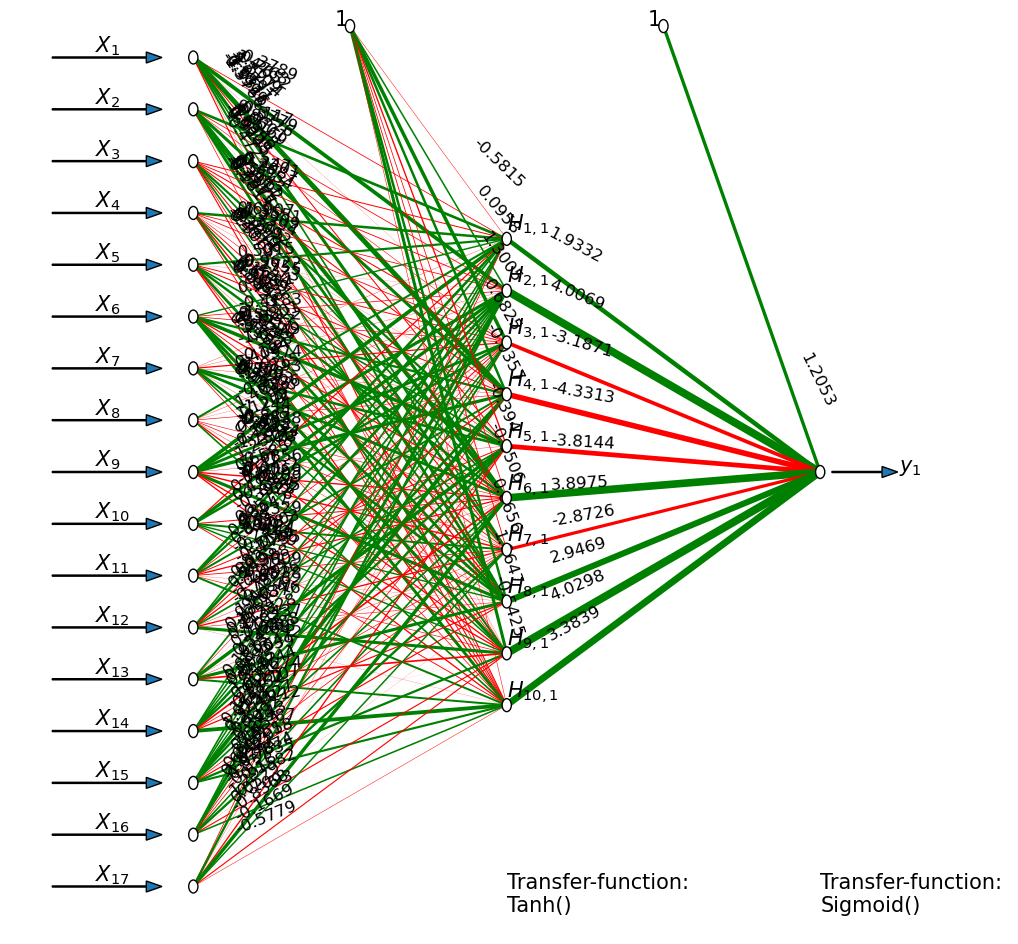


Generalization error/average error rate: 50.36%
Ran exercise 8.2.2.


In [66]:
# exercise 8.2.2
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from sklearn import model_selection
from toolbox_02450 import train_neural_net, draw_neural_net, visualize_decision_boundary
import torch

# Load Matlab data file and extract variables of interest
X = Data
y = Label
N, M = X.shape

# Normalize data
X = stats.zscore(X)
Attributes= np.asarray(df.columns[1:].str.slice(0, 3)) 
attributeNames = Attributes.tolist()
print(Attributes)
C = len(classNames)

# K-fold CrossValidation (4 folds here to speed up this example)
K = 4
CV = model_selection.KFold(K,shuffle=True)



# Define the model structure
n_hidden_units = 10 # number of hidden units in the signle hidden layer
# The lambda-syntax defines an anonymous function, which is used here to 
# make it easy to make new networks within each cross validation fold
model = lambda: torch.nn.Sequential(
                    torch.nn.Linear(M, n_hidden_units), #M features to H hiden units
                    # 1st transfer function, either Tanh or ReLU:
                    torch.nn.Tanh(),                            #torch.nn.ReLU(),
                    torch.nn.Linear(n_hidden_units, 1), # H hidden units to 1 output neuron
                    torch.nn.Sigmoid() # final tranfer function
                    )
# Since we're training a neural network for binary classification, we use a 
# binary cross entropy loss (see the help(train_neural_net) for more on
# the loss_fn input to the function)
loss_fn = torch.nn.BCELoss()
# Train for a maximum of 10000 steps, or until convergence (see help for the 
# function train_neural_net() for more on the tolerance/convergence))
max_iter = 10000
print('Training model of type:\n{}\n'.format(str(model())))

# Do cross-validation:
errors = [] # make a list for storing generalizaition error in each loop
# Loop over each cross-validation split. The CV.split-method returns the 
# indices to be used for training and testing in each split, and calling 
# the enumerate-method with this simply returns this indices along with 
# a counter k:
for k, (train_index, test_index) in enumerate(CV.split(X,y)): 
    print('\nCrossvalidation fold: {0}/{1}'.format(k+1,K))    
    
    # Extract training and test set for current CV fold, 
    # and convert them to PyTorch tensors
    X_train = torch.Tensor(X[train_index,:] )
    y_train = torch.Tensor(y[train_index] )
    X_test = torch.Tensor(X[test_index,:] )
    y_test = torch.Tensor(y[test_index] )
    
    # Go to the file 'toolbox_02450.py' in the Tools sub-folder of the toolbox
    # and see how the network is trained (search for 'def train_neural_net',
    # which is the place the function below is defined)
    net, final_loss, learning_curve = train_neural_net(model,
                                                       loss_fn,
                                                       X=X_train,
                                                       y=y_train.unsqueeze(1),
                                                       n_replicates=3,
                                                       max_iter=max_iter)
    
    print('\n\tBest loss: {}\n'.format(final_loss))
    
    # Determine estimated class labels for test set
    y_sigmoid = net(X_test) # activation of final note, i.e. prediction of network
    y_test_est = (y_sigmoid > .5).type(dtype=torch.uint8) # threshold output of sigmoidal function
    y_test = y_test.type(dtype=torch.uint8)
    # Determine errors and error rate
    e = (y_test_est != y_test)
    error_rate = (sum(e).type(torch.float)/len(y_test)).data.numpy()
    errors.append(error_rate) # store error rate for current CV fold 
    
    # # Make a subplot for current cross validation fold that displays the 
    # # decision boundary over the original data, "background color" corresponds
    # # to the output of the sigmoidal transfer function (i.e. before threshold),
    # # white areas are areas of uncertainty, and a deaper red/blue means 
    # # that the network "is more sure" of a given class.
    # plt.figure(decision_boundaries.number)
    # plt.subplot(subplot_size_1,subplot_size_2,k+1)
    # plt.title('CV fold {0}'.format(k+1),color=color_list[k])
    # predict = lambda x: net(torch.tensor(x, dtype=torch.float)).data.numpy()
    # visualize_decision_boundary(predict, X, y, # provide data, along with function for prediction
    #                             attributeNames, classNames, # provide information on attribute and class names
    #                             train=train_index, test=test_index, # provide information on partioning
    #                             show_legend=k==(K-1)) # only display legend for last plot
    
    


# Display a diagram of the best network in last fold
print('Diagram of best neural net in last fold:')
weights = [net[i].weight.data.numpy().T for i in [0,2]]
biases = [net[i].bias.data.numpy() for i in [0,2]]
tf =  [str(net[i]) for i in [1,3]]
draw_neural_net(weights, biases, tf)

# Print the average classification error rate
print('\nGeneralization error/average error rate: {0}%'.format(round(100*np.mean(errors),4)))

print('Ran exercise 8.2.2.')

# KNN

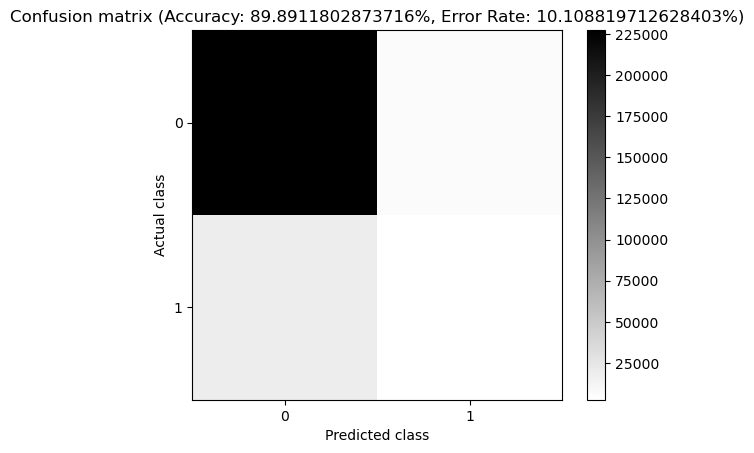

In [ ]:
K=3

# Distance metric (corresponds to 2nd norm, euclidean distance).
# You can set dist=1 to obtain manhattan distance (cityblock distance).
dist= 2
#metric = 'minkowski'
#metric_params = {} # no parameters needed for minkowski

# You can set the metric argument to 'cosine' to determine the cosine distance
metric = 'cosine' 
metric_params = {} # no parameters needed for cosine

# To use a mahalonobis distance, we need to input the covariance matrix, too:
#metric='mahalanobis'
#metric_params={'V': cov(X_train, rowvar=False)}

# Fit classifier and classify the test points
knclassifier = KNeighborsClassifier(n_neighbors=K, p=dist, 
                                    metric=metric,
                                    metric_params=metric_params)
knclassifier.fit(X_train, y_train)
y_est = knclassifier.predict(X_test)


# # Plot the classfication results
# styles = ['ob', 'or', 'og', 'oy']
# for c in range(C):
#     class_mask = (y_est==c)
#     plot(X_test[class_mask,0], X_test[class_mask,1], styles[c], markersize=10)
#     plot(X_test[class_mask,0], X_test[class_mask,1], 'kx', markersize=8)
# title('Synthetic data classification - KNN');

# Compute and plot confusion matrix
cm = confusion_matrix(y_test, y_est);
accuracy = 100*cm.diagonal().sum()/cm.sum(); error_rate = 100-accuracy;
figure(2);
imshow(cm, cmap='binary', interpolation='None');
colorbar()
xticks(range(C)); yticks(range(C));
xlabel('Predicted class'); ylabel('Actual class');
title('Confusion matrix (Accuracy: {0}%, Error Rate: {1}%)'.format(accuracy, error_rate));

show()


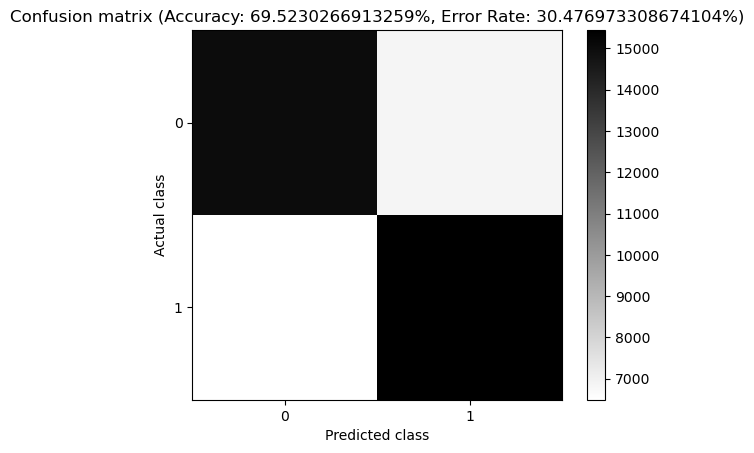

In [ ]:
K=3

# Distance metric (corresponds to 2nd norm, euclidean distance).
# You can set dist=1 to obtain manhattan distance (cityblock distance).
dist= 2
#metric = 'minkowski'
#metric_params = {} # no parameters needed for minkowski

# You can set the metric argument to 'cosine' to determine the cosine distance
metric = 'cosine' 
metric_params = {} # no parameters needed for cosine

# To use a mahalonobis distance, we need to input the covariance matrix, too:
#metric='mahalanobis'
#metric_params={'V': cov(X_train, rowvar=False)}

# Fit classifier and classify the test points
knclassifier = KNeighborsClassifier(n_neighbors=K, p=dist, 
                                    metric=metric,
                                    metric_params=metric_params)
knclassifier.fit(X_train, y_train)
y_est = knclassifier.predict(X_test)


# # Plot the classfication results
# styles = ['ob', 'or', 'og', 'oy']
# for c in range(C):
#     class_mask = (y_est==c)
#     plot(X_test[class_mask,0], X_test[class_mask,1], styles[c], markersize=10)
#     plot(X_test[class_mask,0], X_test[class_mask,1], 'kx', markersize=8)
# title('Synthetic data classification - KNN');

# Compute and plot confusion matrix
cm = confusion_matrix(y_test, y_est);
accuracy = 100*cm.diagonal().sum()/cm.sum(); error_rate = 100-accuracy;
figure(2);
imshow(cm, cmap='binary', interpolation='None');
colorbar()
xticks(range(C)); yticks(range(C));
xlabel('Predicted class'); ylabel('Actual class');
title('Confusion matrix (Accuracy: {0}%, Error Rate: {1}%)'.format(accuracy, error_rate));

show()
